# Naive Bayes High Low Return Prediction Analysis based on Thomas Wiecki 's Post
**German Hernandez**

Based on the post [Machine Learning on Quantopian - Thomas Wiecki ](https://www.quantopian.com/posts/machine-learning-on-quantopian) in Quantopian

This Notebook uses a **Gaussian Naive Bayes model** to predict if a stock will have a return **n_fwd_days** after that will be in the  **top percentile% of returns (class 1)** of the **lower  percentile% (class -1)** using as input variables the returns of 1,2,3,,4,5,6,7,8,9 and 10 days before .

In [1]:
n_fwd_days = 5 # number of days to compute returns over

percentile = 25 # target percetile of the prediction

We use dayly returns of the good quality Quantopian tradable stocks [QTradableStocksUS()](https://www.quantopian.com/posts/working-on-our-best-universe-yet-qtradablestocksus) in a period of between the **start** and **end** dates.

In [5]:
from quantopian.pipeline.filters import QTradableStocksUS
universe = QTradableStocksUS()
from quantopian.pipeline import Pipeline, CustomFactor
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.optimize import TargetWeights
from quantopian.pipeline.factors import Returns


import pandas as pd
start = pd.Timestamp("2018-05-26")
end = pd.Timestamp("2018-09-26")

We use the [Quantopian Pipeline API](https://www.quantopian.com/tutorials/pipeline) that allows to build preprocesing filters form multiple stokcs to calcute the decision variables that we want use in trading algorithm.

We import the **Returns** function form pipeline because our input variables are past returns and our predicted class depends on the n_fwd_days ahead return.

## Building the training and testing data set

In [6]:
from quantopian.pipeline.factors import Returns

We define the function **make_factors()** that define the fucntions that will calculate the input variables for the classfication, in Quantopian the input variables used to make decision in trading algorithsm are called **factors**

We define a function inside make_factors() for ecah one of the  1,2,3,,4,5,6,7,8,9 and 10 previous returns that we are using as input variables, in order to to this we call Returns(), one of the [Built-in Factors](https://www.quantopian.com/help#module-quantopian_pipeline_factors) in the the [Quantopian Pipeline API] Returns is only called with window_lengt parameter(number of days of caculate te return)  so is using the default inputs= [USEquityPricing.close] but returns can be used other inputs like inputs=[USEquityPricing.open]

The function **make_factors()** returns a list of names and pinter to the fucntions that will be used to buld the pipeline that calculates the input variables.

In [26]:
def make_factors():
    def Volume():
        return USEquityPricing.volume.latest
    def earning_yield():
        return Fundamentals.earning_yield.latest
    def cash_return():
        return Returns(window_length=2)
    def Asset_Growth_2d():
        return Returns(window_length=3)
    def Asset_Growth_3d():
        return Returns(window_length=4)
    def Asset_Growth_4d():
        return Returns(window_length=7)
    def style_score():
        return Fundamentals.style_score.latest
    def value_score():
        return Fundamentals.value_score.latest
    def Return():
        return Returns(inputs=[USEquityPricing.open],window_length=5)
        
    all_factors = {
        'Volume': Volume,
        'earning_yield': earning_yield,
        'cash_return': cash_return,
        'Asset_Growth_2d': Asset_Growth_2d,
        'Asset_Growth_3d': Asset_Growth_2d,
        'Asset_Growth_4d': Asset_Growth_4d,
        'style_score': style_score,
        'value_score': value_score,
        'Return': Return,
        
    }     

    return all_factors

factors = make_factors()

factors

{'Asset_Growth_2d': <function __main__.Asset_Growth_2d>,
 'Asset_Growth_3d': <function __main__.Asset_Growth_2d>,
 'Asset_Growth_4d': <function __main__.Asset_Growth_4d>,
 'Return': <function __main__.Return>,
 'Volume': <function __main__.Volume>,
 'cash_return': <function __main__.cash_return>,
 'earning_yield': <function __main__.earning_yield>,
 'style_score': <function __main__.style_score>,
 'value_score': <function __main__.value_score>}

We import the **Pipeline** function from the [Quantopian Pipeline API](https://www.quantopian.com/tutorials/pipeline) that build a preprocesing filters from a dictionary of factors names and pointers.

In [27]:
from quantopian.pipeline import Pipeline

We use the Pipeline to define the **make_history_pipeline()** that will produce the filter that will be applied to obtain build datafarem with the information of the input and target variables.

In [47]:
from quantopian.pipeline.data.builtin import USEquityPricing


def make_history_pipeline(factors, universe, n_fwd_days=5):
    
    # Build dictionary of factors names and definitions used to calculate the information of the input variables 
    factor_ranks = {name: f() for name, f in factors.iteritems()}
    
    # Add to the dictionary the factor name and definitios used to calculate the information of the target variable
    factor_ranks['Returns'] = Returns(inputs=[USEquityPricing.open],window_length=n_fwd_days)
    
    print factor_ranks
    
    pipe = Pipeline(screen=universe, columns=factor_ranks)
    
    return pipe

history_pipe = make_history_pipeline(factors, universe, n_fwd_days=n_fwd_days)

history_pipe

{'Asset_Growth_3d': Returns([EquityPricing.close], 3), 'Return': Returns([EquityPricing<US>.open], 5), 'earning_yield': Latest([Fundamentals<US>.earning_yield], 1), 'Asset_Growth_4d': Returns([EquityPricing.close], 7), 'cash_return': Returns([EquityPricing.close], 2), 'Volume': Latest([EquityPricing<US>.volume], 1), 'Returns': Returns([EquityPricing<US>.open], 5), 'Asset_Growth_2d': Returns([EquityPricing.close], 3), 'value_score': Latest([Fundamentals<US>.value_score], 1), 'style_score': Latest([Fundamentals<US>.style_score], 1)}


We import the **run_pipeline** function from the [Quantopian Pipeline API](https://www.quantopian.com/tutorials/pipeline) that receives a pipe, a star_date and end_date, and  builds data frame with the the information of the input and target variables in that period.

In [48]:
from quantopian.research import run_pipeline

We call  **run_pipeline** with the history_pipe between to between the **start** and **end** dates.

In [49]:
from time import time
start_timer = time()
results = run_pipeline(history_pipe, start_date=start, end_date=end)
results.index.names = ['date', 'security']
end_timer = time()
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

Time to run pipeline 5.36 secs


In [50]:
results.head()

Asset_Growth_2d  Asset_Growth_3d  \
date                      security                                              
2018-05-29 00:00:00+00:00 Equity(2 [ARNC])         -0.010730        -0.010730   
                          Equity(24 [AAPL])         0.000690         0.000690   
                          Equity(41 [ARCB])        -0.003178        -0.003178   
                          Equity(52 [ABM])         -0.005106        -0.005106   
                          Equity(53 [ABMD])        -0.004295        -0.004295   

                                             Asset_Growth_4d    Return  \
date                      security                                       
2018-05-29 00:00:00+00:00 Equity(2 [ARNC])          0.015419  0.015969   
                          Equity(24 [AAPL])         0.008449  0.001223   
                          Equity(41 [ARCB])        -0.026887 -0.007254   
                          Equity(52 [ABM])         -0.029065 -0.025109   
                          Equity(53 [ABMD])         0.037600  0.024788   

                                              Returns      Volume  \
date                      security                                  
2018-05-29 00:00:00+00:00 Equity(2 [ARNC])   0.015969   2187936.0   
                          Equity(24 [AAPL])  0.001223  13694693.0   
                          Equity(41 [ARCB]) -0.007254    254283.0   
                          Equity(52 [ABM])  -0.025109    534606.0   
                          Equity(53 [ABMD])  0.024788    259164.0   

                                             cash_return  earning_yield  \
date                      security                                        
2018-05-29 00:00:00+00:00 Equity(2 [ARNC])     -0.002704        -0.0364   
                          Equity(24 [AAPL])     0.001966         0.0550   
                          Equity(41 [ARCB])    -0.022845         0.0618   
                          Equity(52 [ABM])      0.000000         0.0503   
                          Equity(53 [ABMD])    -0.001141         0.0062   

                                             style_score  value_score  
date                      security                                     
2018-05-29 00:00:00+00:00 Equity(2 [ARNC])      142.9652     85.23033  
                          Equity(24 [AAPL])     142.2381     50.99591  
                          Equity(41 [ARCB])     149.1617     66.49705  
                          Equity(52 [ABM])      134.2942     58.47851  
                          Equity(53 [ABMD])     471.4387      4.71541

In [51]:
results.tail()

Asset_Growth_2d  \
date                      security                                  
2018-09-26 00:00:00+00:00 Equity(51542 [DNLI])           0.011439   
                          Equity(51576 [CASA])          -0.054904   
                          Equity(51580 [NMRK])          -0.022065   
                          Equity(51615 [LILA_K])        -0.008349   
                          Equity(51618 [NTR])            0.008210   

                                                  Asset_Growth_3d  \
date                      security                                  
2018-09-26 00:00:00+00:00 Equity(51542 [DNLI])           0.011439   
                          Equity(51576 [CASA])          -0.054904   
                          Equity(51580 [NMRK])          -0.022065   
                          Equity(51615 [LILA_K])        -0.008349   
                          Equity(51618 [NTR])            0.008210   

                                                  Asset_Growth_4d    Return  \
date                      security                                            
2018-09-26 00:00:00+00:00 Equity(51542 [DNLI])           0.133547  0.027330   
                          Equity(51576 [CASA])          -0.022336 -0.028894   
                          Equity(51580 [NMRK])          -0.008057  0.051048   
                          Equity(51615 [LILA_K])         0.045477  0.034816   
                          Equity(51618 [NTR])           -0.002247 -0.024098   

                                                   Returns     Volume  \
date                      security                                      
2018-09-26 00:00:00+00:00 Equity(51542 [DNLI])    0.027330   225525.0   
                          Equity(51576 [CASA])   -0.028894   562221.0   
                          Equity(51580 [NMRK])    0.051048   298995.0   
                          Equity(51615 [LILA_K])  0.034816   245194.0   
                          Equity(51618 [NTR])    -0.024098  1162055.0   

                                                  cash_return  earning_yield  \
date                      security                                             
2018-09-26 00:00:00+00:00 Equity(51542 [DNLI])       0.020192        -0.1006   
                          Equity(51576 [CASA])      -0.009056         0.0470   
                          Equity(51580 [NMRK])      -0.036522         0.0342   
                          Equity(51615 [LILA_K])    -0.004655        -0.2245   
                          Equity(51618 [NTR])        0.014572         0.0225   

                                                  style_score  value_score  
date                      security                                          
2018-09-26 00:00:00+00:00 Equity(51542 [DNLI])            NaN          NaN  
                          Equity(51576 [CASA])            NaN          NaN  
                          Equity(51580 [NMRK])       339.0609     23.77479  
                          Equity(51615 [LILA_K])     220.1531     67.83053  
                          Equity(51618 [NTR])        117.1945     10.46960

We extract, shift,mask,recode and split the information for the **X_train and X_test  (input variables)** and the **Y_train and Y_test(target)** variable, using the information in the **results** dataframe.

We split our data into **training** (80%) and testing (20%).

In [52]:
import numpy as np

training = 0.8

In [53]:
results_wo_returns = results.copy()
returns = results_wo_returns.pop('Returns')
Y = returns.unstack().values
X = results_wo_returns.to_panel() 
X = X.swapaxes(2, 0).swapaxes(0, 1).values # (factors, time, stocks) -> (time, stocks, factors)

In [54]:
n_time, n_stocks, n_factors = X.shape
train_size = np.int16(np.round(training * n_time))
X_train_aux, Y_train_aux = X[:train_size, ...], Y[:train_size]
X_test_aux, Y_test_aux = X[(train_size+n_fwd_days):, ...], Y[(train_size+n_fwd_days):]

We check how many **(days, stocks, varaibles)**  we have in the training set before fitering nans

In [55]:
n_time, n_stocks, n_factors = X_train_aux.shape
print X_train_aux.shape, n_time* n_stocks

(68, 9562, 9) 650216


We check how many **(days, stocks, varaibles)** we have in the testing set before fitering nans

In [56]:
n_time, n_stocks, n_factors = X_test_aux.shape
print X_test_aux.shape, n_time* n_stocks

(12, 9562, 9) 114744


We crate a helper function **shift_recode_mask_data ()** that 

* Shift factors (input variables - returns) to align these with the future target (return n_fwd_days days ahead).
* Recode the target Y as 1 and -1
* Eliminates examples thathave nan values or are not in the classes 1 and -1

In [57]:
def shift_recode_mask_data(X, Y, upper_percentile=100-percentile, lower_percentile=percentile, n_fwd_days=1):
    # Shift X to match factors at t to returns at t+n_fwd_days (we want to predict future returns after all)
    shifted_X = np.roll(X, n_fwd_days+1, axis=0)
    
    # Slice off rolled elements
    X = shifted_X[n_fwd_days+1:]
    Y = Y[n_fwd_days+1:]
    
    n_time, n_stocks, n_factors = X.shape
    
    # Look for biggest up and down movers
    upper = np.nanpercentile(Y, upper_percentile, axis=1)[:, np.newaxis]
    lower = np.nanpercentile(Y, lower_percentile, axis=1)[:, np.newaxis]
  
    upper_mask = (Y >= upper)
    lower_mask = (Y <= lower)
    
    mask = upper_mask | lower_mask # This also drops nans
    mask = mask.flatten()
    
    # Only try to predict whether a stock moved up/down relative to other stocks
    Y_binary = np.zeros(n_time * n_stocks)
    Y_binary[upper_mask.flatten()] = 1
    Y_binary[lower_mask.flatten()] = -1
    
    # Flatten X
    X = X.reshape((n_time * n_stocks, n_factors))

    # Drop stocks that did not move much (i.e. are not in the upper_percentile or the lower_percentile )
    X = X[mask]
    Y_binary = Y_binary[mask]
    
    # Drop stocks with nan returns
    masknan=  ~np.isnan(X).any(axis=1)
    X = X[masknan]
    Y_binary = Y_binary[masknan]
    
    return X, Y_binary

In [58]:
X_train, Y_train = shift_recode_mask_data(X_train_aux, Y_train_aux, n_fwd_days=n_fwd_days)
X_test, Y_test = shift_recode_mask_data(X_test_aux, Y_test_aux, n_fwd_days=n_fwd_days, 
                                             lower_percentile=50, 
                                             upper_percentile=50)

/venvs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 592844 but corresponding boolean dimension is 142166
/venvs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 592844 but corresponding boolean dimension is 142166
/venvs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 592844 but corresponding boolean dimension is 142166
/venvs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 592844 but corresponding boolean dimension is 142166
/venvs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: boolean index did not match

We check how many examples we have in the traning and  testing set after applying shift_recode_mask_data ()

In [59]:
X_train.shape, X_test.shape

((15184, 9), (3472, 9))

## Explore the data visualy

In [60]:
import matplotlib.pyplot as plt

X = X_train
Y = Y_train

color = [] 
for i in range(len(Y)):
    if Y[i] == 1:
        color.append('green')
    else:
        color.append('red')
        


IndexError: index 9 is out of bounds for axis 1 with size 9

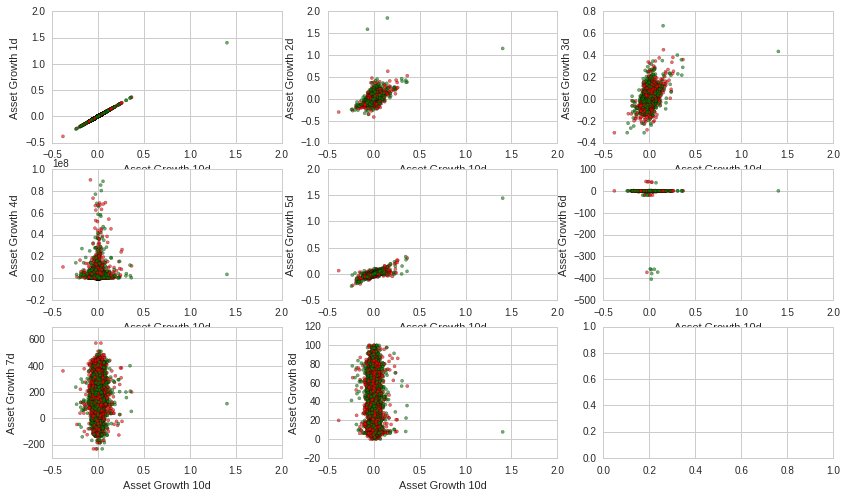

In [61]:
plt.subplot(3, 3, 1)
plt.scatter(X[:, 0], X[:, 1], c=color, alpha= 0.6, s=10, edgecolor='k') 
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 1d')

plt.subplot(3, 3, 2)
plt.scatter(X[:, 0], X[:, 2], c=color, alpha= 0.6, s=10, edgecolor='k')  
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 2d')

plt.subplot(3, 3, 3)
plt.scatter(X[:, 0], X[:, 3], c=color, alpha= 0.6, s=10, edgecolor='k') 
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 3d')

plt.subplot(3, 3, 4)
plt.scatter(X[:, 0], X[:, 4], c=color, alpha= 0.6, s=10, edgecolor='k') 
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 4d')

plt.subplot(3, 3, 5)
plt.scatter(X[:, 0], X[:, 5], c=color, alpha= 0.6, s=10, edgecolor='k') 
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 5d')

plt.subplot(3, 3, 6)
plt.scatter(X[:, 0], X[:, 6], c=color, alpha= 0.6, s=10, edgecolor='k') 
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 6d')

plt.subplot(3, 3, 7)
plt.scatter(X[:, 0], X[:, 7], c=color, alpha= 0.6, s=10, edgecolor='k')  
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 7d')

plt.subplot(3, 3, 8)
plt.scatter(X[:, 0], X[:, 8], c=color, alpha= 0.6, s=10, edgecolor='k') 
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 8d')

plt.subplot(3, 3, 9)
plt.scatter(X[:, 0], X[:, 9], c=color, alpha= 0.6, s=10, edgecolor='k') 
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 9d')

In [ ]:
x = X[:,0]

mask = (Y == 1)
xg = x[mask]

mask = (Y == -1)
xr = x[mask]

xlim = (-2, 2)
bins = np.linspace(xlim[0], xlim[1], 200)

plt.hist(xr, bins, alpha=0.6,  histtype='stepfilled', label='red',  color='red')
plt.hist(xg, bins, alpha=0.6,  histtype='stepfilled', label='green', color='green' )
plt.legend(loc='upper right')
plt.xlabel('Asset Growth 10d')
plt.ylabel('Probability by class ')
plt.show()

In [ ]:
import pandas as pd
labels = ['Asset Growth 10d',
          'Asset Growth 1d',
          'Asset Growth 2d',
          'Asset Growth 3d',
          'Asset Growth 4d',
          'Asset Growth 5d',
          'Asset Growth 6d',
          'Asset Growth 7d',
          'Asset Growth 8d',
          'Asset Growth 9d']      
df = pd.DataFrame(X_train, columns=labels)
df['target'] = Y_train
df.sample(20)

In [ ]:
import seaborn as sns
sns.set()
palette = ['#FF0000','#00FF00']
sns.set_palette(palette)
sns.pairplot(df, vars=labels,  hue='target', diag_kind = 'kde', plot_kws = {'alpha': 0.6, 's': 10, 'edgecolor': 'k'});

## Train the Gaussian Naive Bayes model

In [62]:
start_timer = time()

# Train classifier
#from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X_train, Y_train);

end_timer = time()

In [63]:
print "Time to train : %0.2f secs" % (end_timer - start_timer)

Time to train : 0.33 secs


In [64]:
from sklearn import metrics

Y_pred = clf.predict(X_train)
print('Accuracy on train set = {:.2f}%'.format(metrics.accuracy_score(Y_train, Y_pred) * 100))

Accuracy on train set = 100.00%


In [65]:
# Predict!
Y_pred = clf.predict(X_test)

Y_pred_prob = clf.predict_proba(X_test)

In [66]:
print 'Predictions:', Y_pred
print 'Probabilities of class == 1:', Y_pred_prob[:, 1] * 100

Predictions: [-1. -1. -1. ...,  1. -1. -1.]
Probabilities of class == 1: [   0.    0.    0. ...,  100.    0.    0.]


In [68]:
print('Accuracy on test set = {:.2f}%'.format(metrics.accuracy_score(Y_test, Y_pred) * 100))
print('Log-loss = {:.5f}'.format(metrics.log_loss(Y_test, Y_pred_prob)))

Accuracy on test set = 51.64%
Log-loss = 16.70236
